## Table of contents

---

In [118]:
import pandas as pd
import numpy as np
import os 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')


In [2]:
os.listdir()

['dataset', 'notebook.ipynb', 'playground.ipynb', 'README.md']

In [3]:
df = pd.read_csv('./dataset/train.csv')
len(df)

20758

In [4]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


#### Target variable: NObeyesdad

In [5]:
df['NObeyesdad'].value_counts() 

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

Notes:

1. 7 obesity statuses

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

Notes:
1. No missing values across all columns
2. `FAVC`: "Frequency of consumption of high calorie food"
3. `FCVC`: "Frequency of consumption of vegetables"
4. `NCP`: "Number of main meals a day"
5. `CAEC`: "Consumption of food between meals"
6. `CH20`: "Consumption of water daily"
7. `SCC`: "Frequency of an individual monitoring their calorie intake"
8. `FAF`: "Physical activity frequency"
9. `TUE`: "Time using technology devices"
10. `CALC`: "Alcohol consumption"
11. `MTRANS`: "Main transportation mode" 

In [7]:
# rename columns
rename_cols_map = {"FAVC": "frequency_high_calorie_food_intake",
                   "FCVC": "frequency_veg_intake",
                   "NCP": "num_main_meals_daily",
                   "CAEC": "food_intake_btwn_meals",
                   "CH2O": "water_intake_daily",
                   "SCC": "frequency_calorie_monitoring",
                   "FAF": "frequency_physical_activity",
                   "TUE": "time_tech_devices",
                   "CALC": "alcohol_consumption",
                   "MTRANS": "main_transportation"
                   }

df.rename(columns=rename_cols_map, inplace=True)

df.columns = [i.lower() for i in df.columns]

#### Univariate distributions

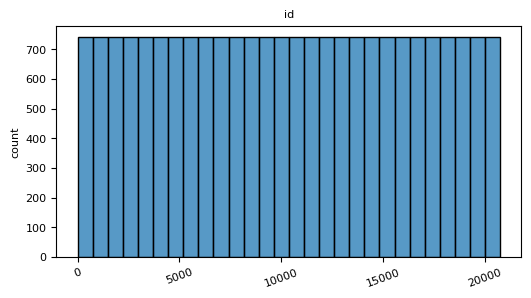

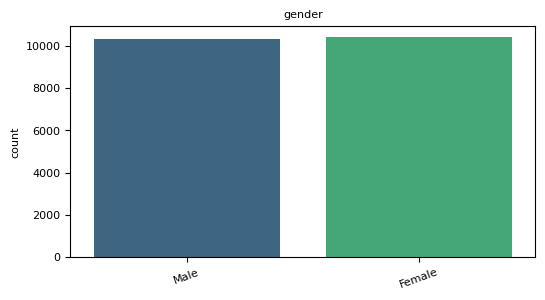

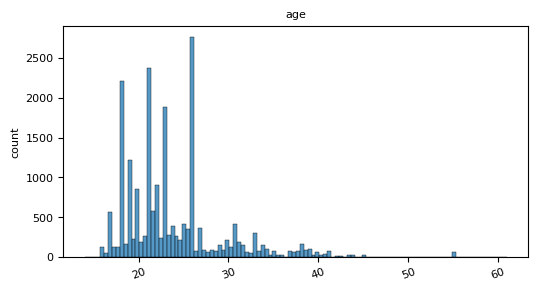

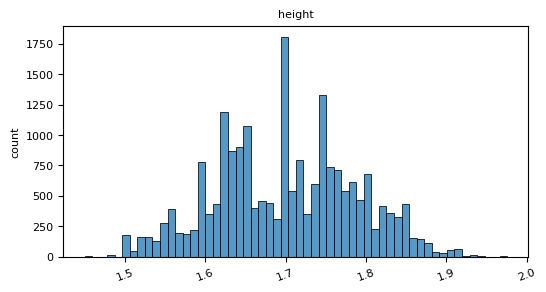

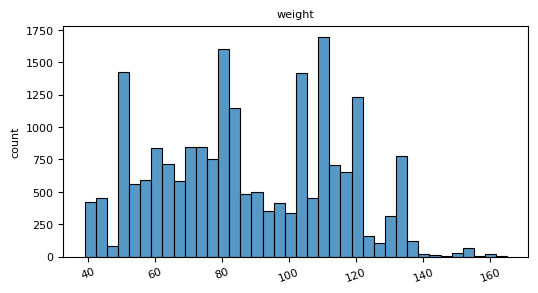

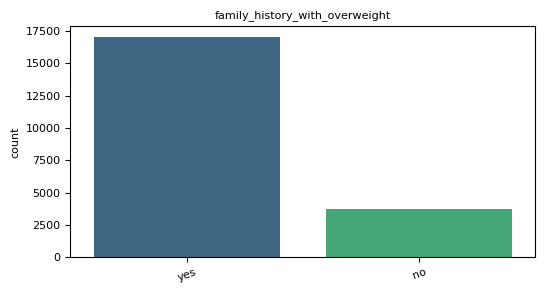

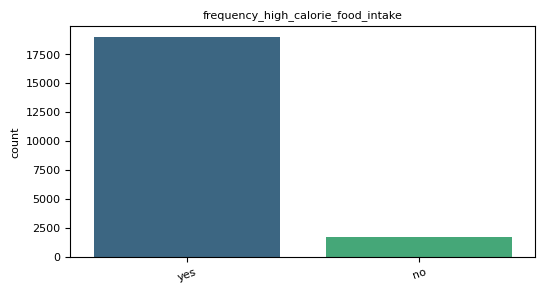

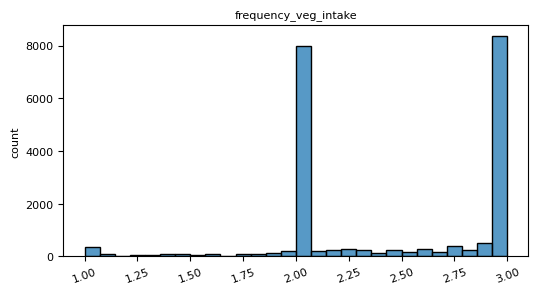

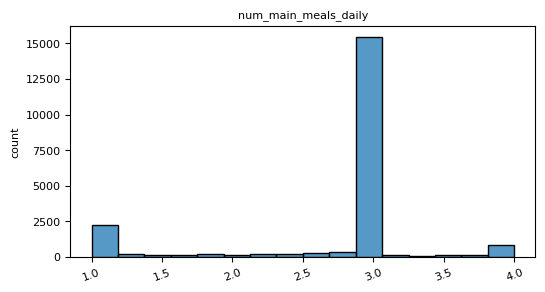

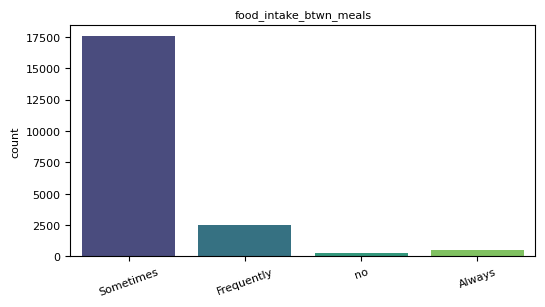

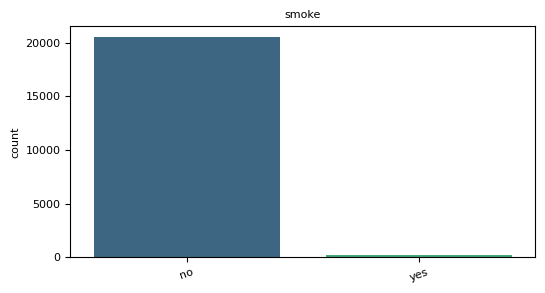

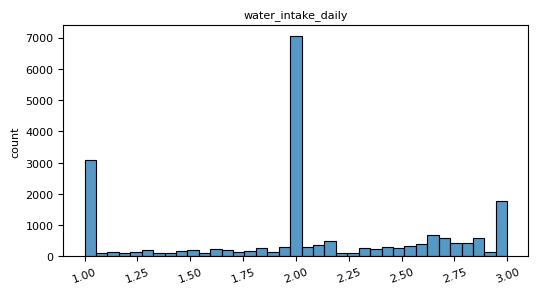

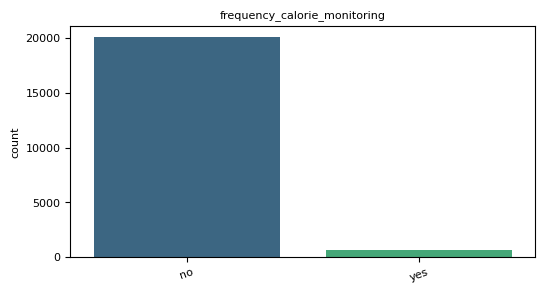

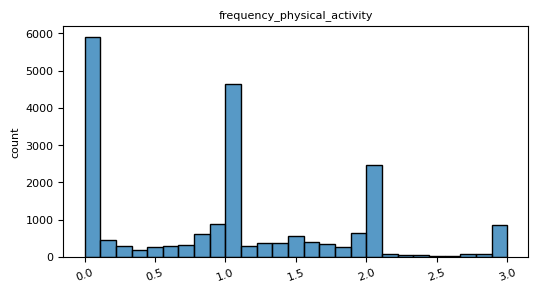

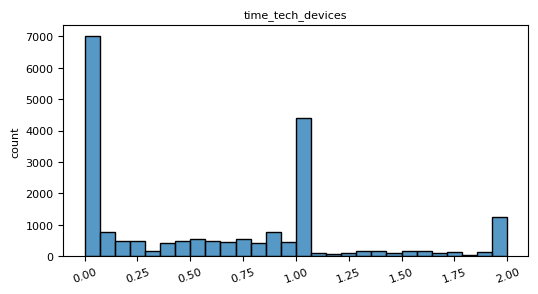

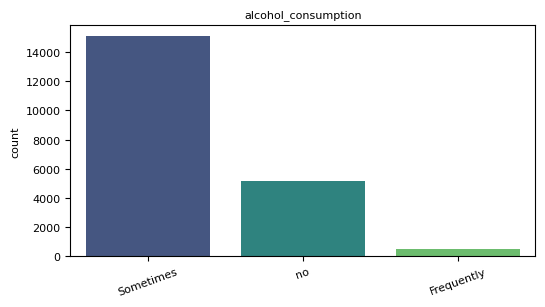

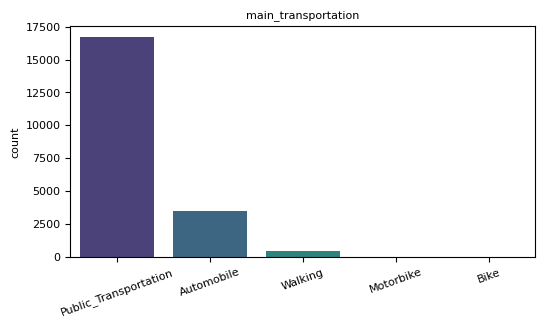

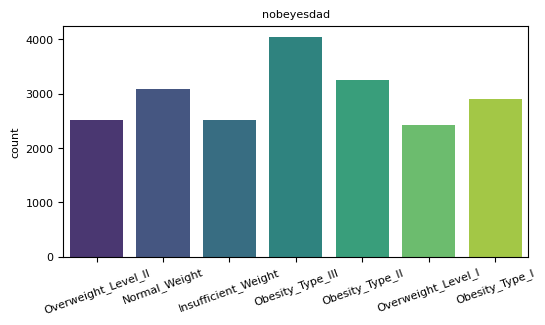

In [8]:
# distribution of each column
for i in df.columns:
    if np.issubdtype(df[i].dtype, np.number):
        plt.figure(figsize=(6,3))
        sns.histplot(data=df, x=i)
    else:
        plt.figure(figsize=(6,3))
        sns.countplot(x=df[i], palette='viridis')

    plt.title(i, fontsize=8)
    plt.xlabel('', fontsize=8)
    plt.xticks(fontsize=8, rotation=20)
    plt.ylabel('count',fontsize=8)
    plt.yticks(fontsize=8)
        

Notes:

1. Other than `Gender`, the other categorical variables seem to have unequal distributions of some categories than others.

#### Bivariate analysis against target variable

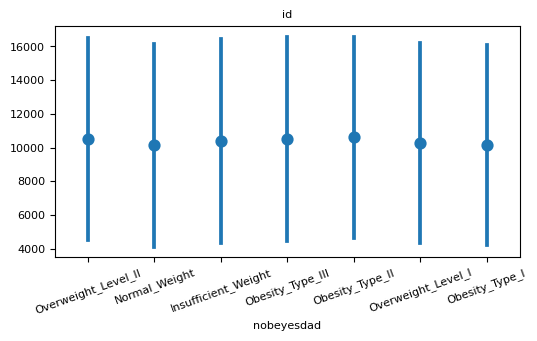

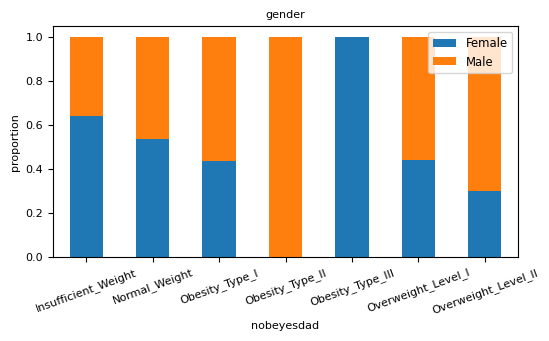

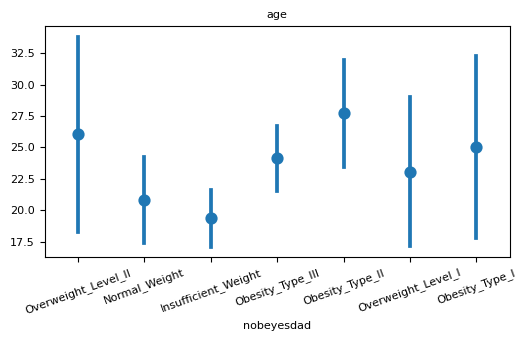

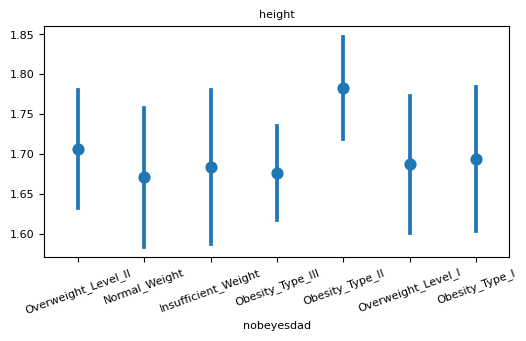

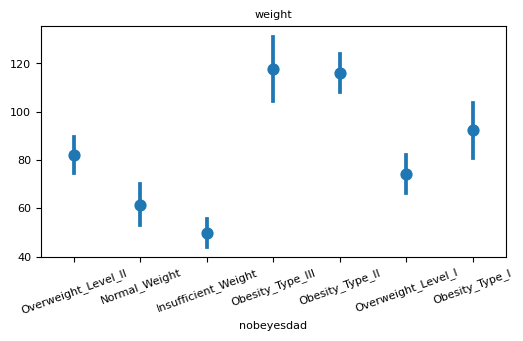

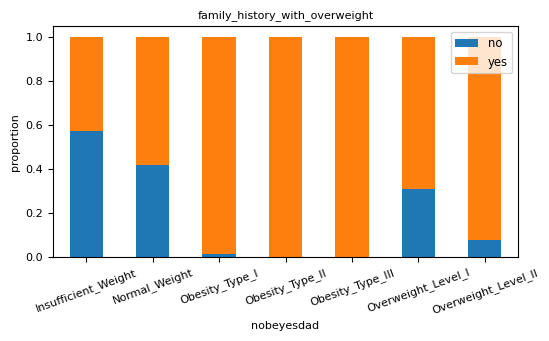

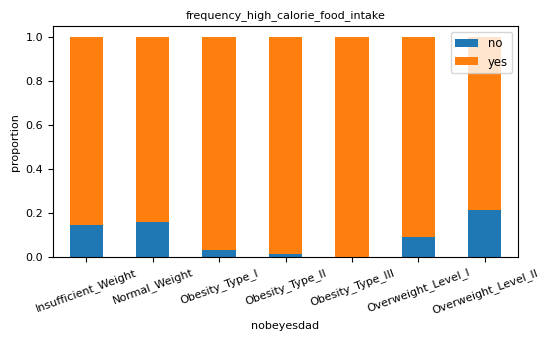

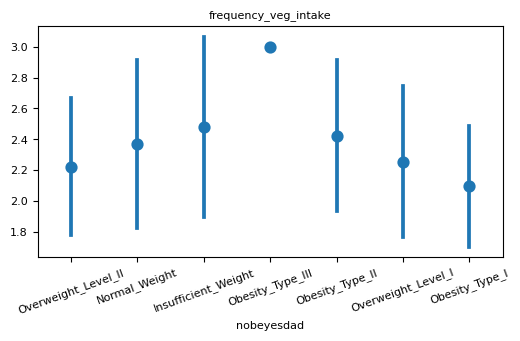

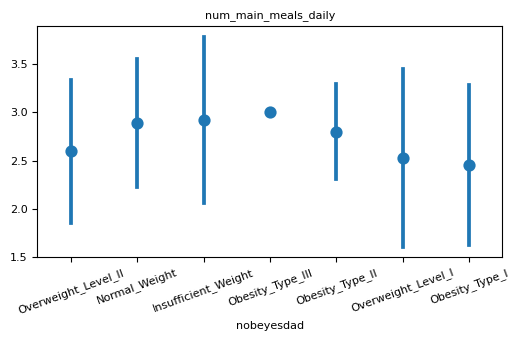

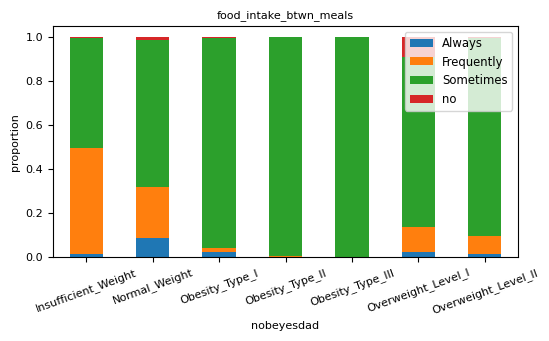

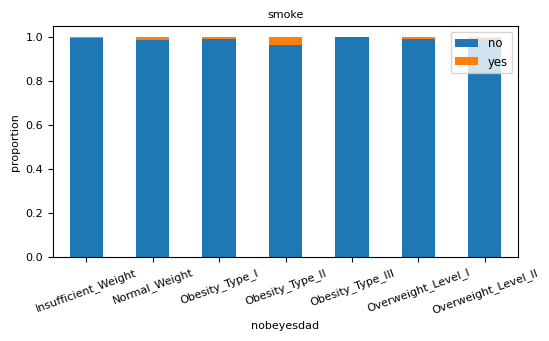

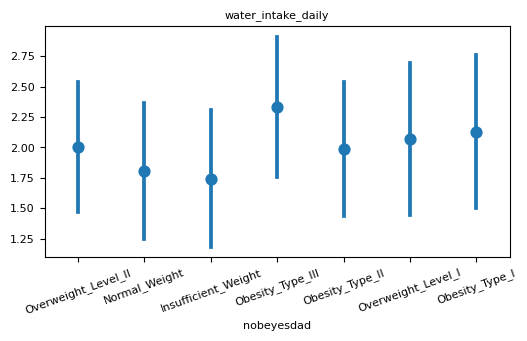

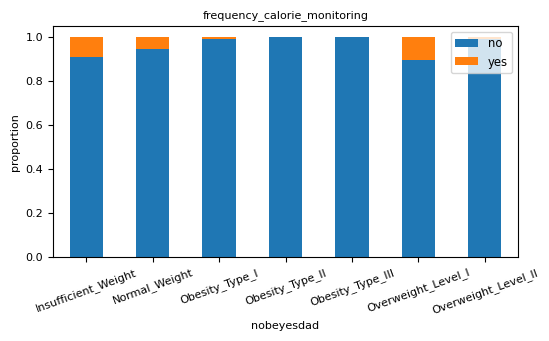

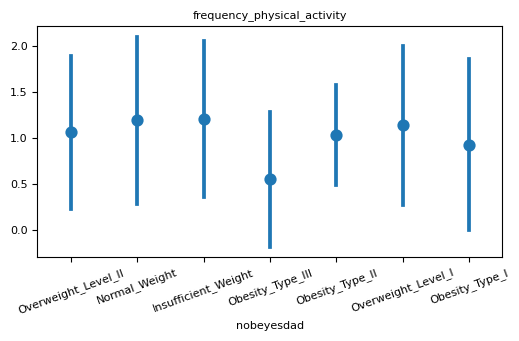

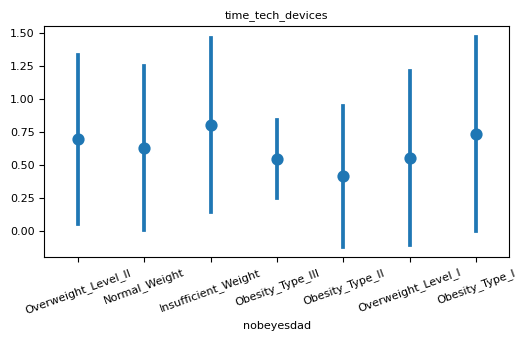

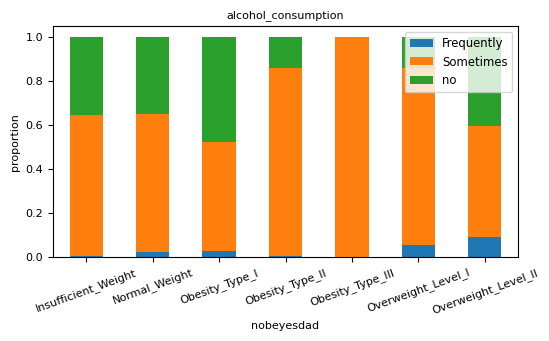

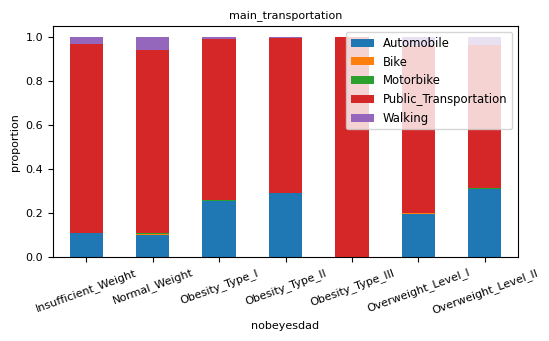

In [9]:
for i in df.columns:
    if i=='nobeyesdad':
        pass 
    else:
        if np.issubdtype(df[i].dtype, np.number):
            plt.figure(figsize=(6,3))
            sns.pointplot(data=df, x='nobeyesdad', y=i, ci='sd', join=False)
            plt.title(i, fontsize=8)
            plt.xlabel('nobeyesdad', fontsize=8)
            plt.xticks(fontsize=8, rotation=20)
            plt.ylabel('')
            plt.yticks(fontsize=8)
        else:
            count = df.groupby(['nobeyesdad',i]).size().reset_index(name='count')
            total = count.groupby('nobeyesdad')['count'].transform('sum')
            count['proportion'] = count['count'] / total 
            plot_df = count.pivot(index='nobeyesdad', columns=i, values='proportion').fillna(0)
            plot_df.plot(kind='bar',stacked=True, figsize=(6,3))
            plt.title(i, fontsize=8)
            plt.xlabel('nobeyesdad', fontsize=8)
            plt.xticks(fontsize=8, rotation=20)
            plt.ylabel('proportion', fontsize=8)
            plt.yticks(fontsize=8)
            plt.legend(loc='upper right', bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')


Notes:

1. Patients with Obesity Type 3 seem to unanimously have many things in common. They seem to be females who are generally in the early to mid 20s, with a family history of being overweight, have a comparatively on-par average height with patients of other obesity risks but weigh significantly more. They seem to consume a lot of high calorie food, vegetables and water, snack "sometimes" between meals, don't exercise frequently, don't track calorie intake, consume alcohol "sometimes" and take public transportation. 
2. Fairly similar traits among patients with Obesity Type 2 in that they too have many things in common, although not as consistently clear as with Obesity Type 3. 
3. The other risk groups have a mix of patient characteristics and are not as clear-cut when visualised in a bivariate manner.

#### Add new features

1. `bmi`: `weight` / (`height`^2)
    - Numeric
2. `healthy_lifestyle`: Healthy or not
    - Categorical (nominal)
    - 'Healthy' defined as someone 
        - Who walks (`main_transportation`='Walking')
        - Does not drink (`alcohol_consumption`='no')
        - Does not consume high calorie food (`frequency_high_calorie_food_intake`='no') 
        - Eats above average consumption of vegetables (`frequency_veg_intake`>mean(`frequency_veg_intake`))
        - Drinks above average consumption of water (`water_intake_daily`>mean(`water_intake_daily`))
        - Exercises above average levels (`frequency_physical_activity`>mean(`frequency_physical_activity`))
3. `total_food_intake`: Multiply `num_main_meals_daily` (number of main meals a day) with values attached to `food_intake_btwn_meals` (consumption of food between meals)
    - Numeric 
    - `food_intake_btwn_meals`: 'Always' -> 4; 'Frequently' -> 3; 'Sometimes' -> 2; 'No' -> 1
4. `healthy diet`: Healthy or not 
    - Categorical (nominal)
    - 'Healthy' defined as someone who 
        - Does not eat high calorie food (`frequency_high_calorie_food_intake`=no)
        - Eats above average consumption of vegetables (`frequency_veg_intake`>mean(`frequency_veg_intake`))
        - Drinks above average consumption of water (`water_intake_daily`>mean(`water_intake_daily`))
5. `unsure_responses`: As a proxy for how honest the self-declared responses to some questions are. I'm making the assumption that patients who input 'Sometimes' for both questions that require these responses are perhaps afraid of answering 'Always'
    - Categorical (nominal)
    - Relevant questions: `food_intake_btwn_meals` and `alcohol_consumption`

In [10]:
# assess responses to some questions 
for i in df.columns:
    if not np.issubdtype(df[i].dtype, np.number):
        print(df[i].value_counts())
        print('\n')

gender
Female    10422
Male      10336
Name: count, dtype: int64


family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64


frequency_high_calorie_food_intake
yes    18982
no      1776
Name: count, dtype: int64


food_intake_btwn_meals
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64


smoke
no     20513
yes      245
Name: count, dtype: int64


frequency_calorie_monitoring
no     20071
yes      687
Name: count, dtype: int64


alcohol_consumption
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64


main_transportation
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


nobeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    

In [11]:
# bmi 
df['bmi'] = df['weight'] / (df['height']**2)

# lifestyle 
avg_frequency_veg_intake = df['frequency_veg_intake'].mean()
avg_water_intake_daily = df['water_intake_daily'].mean()
avg_frequency_physical_activity = df['frequency_physical_activity'].mean()

df['healthy_lifestyle'] = (df['main_transportation']=='Walking') & (df['alcohol_consumption']=='no') & \
                          (df['frequency_high_calorie_food_intake']=='no') & (df['frequency_veg_intake']>=avg_frequency_veg_intake) & \
                          (df['water_intake_daily']>=avg_water_intake_daily) & (df['frequency_physical_activity']>=avg_frequency_physical_activity)
df['healthy_lifestyle'] = df['healthy_lifestyle'].map({True:'healthy', False:'not healthy'})

# total food intake 
caec_map = {'Always': 4, 'Frequently': 3, 'Sometimes': 2, 'no': 1}
df['total_food_intake'] = df['num_main_meals_daily']*df['food_intake_btwn_meals'].map(caec_map)

# diet 
df['healthy_diet'] = (df['frequency_high_calorie_food_intake']=='no') & (df['frequency_veg_intake']>=avg_frequency_veg_intake) & (df['water_intake_daily']>=avg_water_intake_daily)
df['healthy_diet'] = df['healthy_diet'].map({True:'healthy', False:'not healthy'})

# honesty 
df['unsure_responses'] = (df['food_intake_btwn_meals']=='Sometimes') & (df['alcohol_consumption']=='Sometimes')
df['unsure_responses'] = df['unsure_responses'].map({True:'unsure', False:'sure'})


In [12]:
# function 
def add_new_features(df):
    # bmi 
    df['bmi'] = df['weight'] / (df['height']**2)

    # lifestyle 
    avg_frequency_veg_intake = df['frequency_veg_intake'].mean()
    avg_water_intake_daily = df['water_intake_daily'].mean()
    avg_frequency_physical_activity = df['frequency_physical_activity'].mean()

    df['healthy_lifestyle'] = (df['main_transportation']=='Walking') & (df['alcohol_consumption']=='no') & \
                            (df['frequency_high_calorie_food_intake']=='no') & (df['frequency_veg_intake']>=avg_frequency_veg_intake) & \
                            (df['water_intake_daily']>=avg_water_intake_daily) & (df['frequency_physical_activity']>=avg_frequency_physical_activity)
    df['healthy_lifestyle'] = df['healthy_lifestyle'].map({True:'healthy', False:'not healthy'})

    # total food intake 
    caec_map = {'Always': 4, 'Frequently': 3, 'Sometimes': 2, 'no': 1}
    df['total_food_intake'] = df['num_main_meals_daily']*df['food_intake_btwn_meals'].map(caec_map)

    # diet 
    df['healthy_diet'] = (df['frequency_high_calorie_food_intake']=='no') & (df['frequency_veg_intake']>=avg_frequency_veg_intake) & (df['water_intake_daily']>=avg_water_intake_daily)
    df['healthy_diet'] = df['healthy_diet'].map({True:'healthy', False:'not healthy'})   

    # honesty 
    df['unsure_responses'] = (df['food_intake_btwn_meals']=='Sometimes') & (df['alcohol_consumption']=='Sometimes')
    df['unsure_responses'] = df['unsure_responses'].map({True:'unsure', False:'sure'})

    return df 


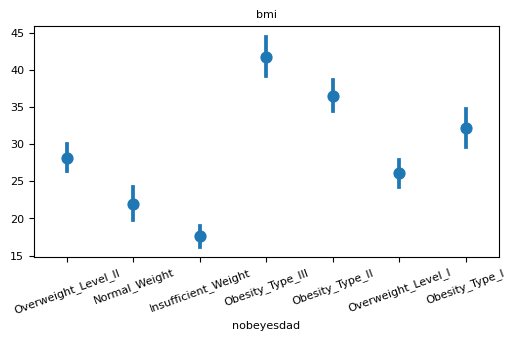

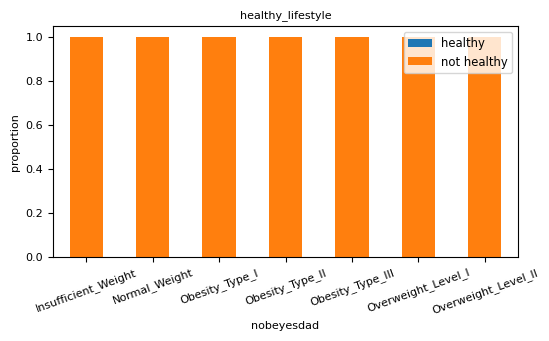

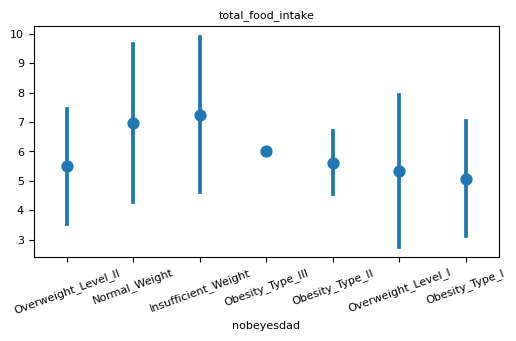

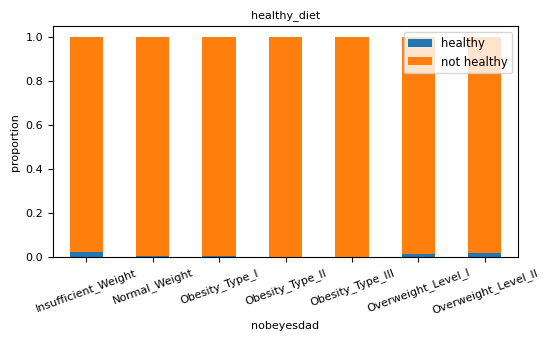

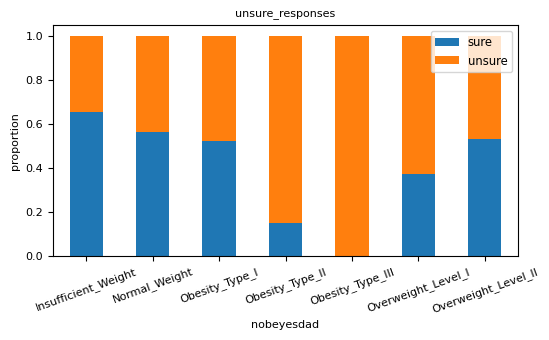

In [13]:
new_features = ['bmi','healthy_lifestyle','total_food_intake','healthy_diet','unsure_responses']

for i in new_features:
    if np.issubdtype(df[i].dtype, np.number):
        plt.figure(figsize=(6,3))
        sns.pointplot(data=df, x='nobeyesdad', y=i, ci='sd', join=False)
        plt.title(i, fontsize=8)
        plt.xlabel('nobeyesdad', fontsize=8)
        plt.xticks(fontsize=8, rotation=20)
        plt.ylabel('')
        plt.yticks(fontsize=8)
    else:
        count = df.groupby(['nobeyesdad',i]).size().reset_index(name='count')
        total = count.groupby('nobeyesdad')['count'].transform('sum')
        count['proportion'] = count['count'] / total 
        plot_df = count.pivot(index='nobeyesdad', columns=i, values='proportion').fillna(0)
        plot_df.plot(kind='bar',stacked=True, figsize=(6,3))
        plt.title(i, fontsize=8)
        plt.xlabel('nobeyesdad', fontsize=8)
        plt.xticks(fontsize=8, rotation=20)
        plt.ylabel('proportion', fontsize=8)
        plt.yticks(fontsize=8)
        plt.legend(loc='upper right', bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

#### Prep dataset

In [14]:
# columns
target = 'nobeyesdad'
x_cols = df.columns.tolist()
x_cols.remove('id')
x_cols.remove(target)

In [15]:
# split dataset
X, y = df[x_cols], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train) + len(X_test) == len(X)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              20758 non-null  object 
 1   age                                 20758 non-null  float64
 2   height                              20758 non-null  float64
 3   weight                              20758 non-null  float64
 4   family_history_with_overweight      20758 non-null  object 
 5   frequency_high_calorie_food_intake  20758 non-null  object 
 6   frequency_veg_intake                20758 non-null  float64
 7   num_main_meals_daily                20758 non-null  float64
 8   food_intake_btwn_meals              20758 non-null  object 
 9   smoke                               20758 non-null  object 
 10  water_intake_daily                  20758 non-null  float64
 11  frequency_calorie_monitoring        20758

In [17]:
# one hot encoding
one_hot_encode = ['gender','family_history_with_overweight','frequency_high_calorie_food_intake',
                  'smoke','frequency_calorie_monitoring','main_transportation',
                  'healthy_lifestyle','healthy_diet','unsure_responses']

X_train_encoded = pd.get_dummies(X_train, columns=one_hot_encode, drop_first=True)

for i in X_train_encoded.columns:
    if X_train_encoded[i].dtype == 'bool':
        X_train_encoded[i] = X_train_encoded[i].astype(int)

# label encoding
label_encode = ['food_intake_btwn_meals','alcohol_consumption']

X_train_encoded['food_intake_btwn_meals'] = X_train_encoded['food_intake_btwn_meals'].map({'no':1,'Sometimes':2,'Frequently':3,'Always':4})
X_train_encoded['alcohol_consumption'] = X_train_encoded['alcohol_consumption'].map({'no':1,'Sometimes':2,'Frequently':3})

In [18]:
# function 
def categorical_encode(df):
    # one hot encoding
    one_hot_encode = ['gender','family_history_with_overweight','frequency_high_calorie_food_intake',
                    'smoke','frequency_calorie_monitoring','main_transportation',
                    'healthy_lifestyle','healthy_diet','unsure_responses']

    df = pd.get_dummies(df, columns=one_hot_encode, drop_first=True)

    for i in df.columns:
        if df[i].dtype == 'bool':
            df[i] = df[i].astype(int)

    # label encoding
    label_encode = ['food_intake_btwn_meals','alcohol_consumption']

    df['food_intake_btwn_meals'] = df['food_intake_btwn_meals'].map({'no':1,'Sometimes':2,'Frequently':3,'Always':4})
    df['alcohol_consumption'] = df['alcohol_consumption'].map({'no':1,'Sometimes':2,'Frequently':3}) 

    return df 

In [19]:
print(X_test.shape)
X_test_encoded = categorical_encode(df=X_test)
print(X_test_encoded.shape)

(4152, 21)
(4152, 24)


#### Evaluation metrics

In [20]:
# function
def classification_evaluation(
    y_test,
    y_pred,
    y_predict_proba,
    labels 
):  
    # accuracy, precision, recall, f1, auc
    accuracy = round(accuracy_score(y_test, y_pred),2)
    precision = round(precision_score(y_test, y_pred, average='micro'),2)
    recall = round(recall_score(y_test, y_pred, average='micro'),2)
    f1 = round(f1_score(y_test, y_pred, average='micro'),2)

    # aucroc
    y_test_binarized = label_binarize(y_test, classes=labels)
    aucroc = round(roc_auc_score(y_test_binarized, y_predict_proba, average='micro'),2)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100).round()
    cm_df_percentage = pd.DataFrame(cm_percentage, index=labels, columns=labels)

    # join metrics
    results = pd.DataFrame(columns=['accuracy','precision','recall','f1','aucroc'])
    results.loc[0] = accuracy,precision,recall,f1,aucroc
    
    print(f"Confusion matrix: \n")
    print(cm_df_percentage)
    print('\n')
    print(results.loc[0])

#### Decision tree

In [21]:
# fit decision tree
de_model = DecisionTreeClassifier(random_state=1)
de_model = de_model.fit(X_train_encoded,y_train)
de_y_pred = de_model.predict(X_test_encoded)
de_y_pred_proba = de_model.predict_proba(X_test_encoded)

In [22]:
# evaluation
classification_evaluation(y_test=y_test, 
                          y_pred=de_y_pred, 
                          y_predict_proba=de_y_pred_proba,
                          labels=de_model.classes_.tolist())

Confusion matrix: 

                     Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Insufficient_Weight                 89.0           10.0             0.0   
Normal_Weight                       11.0           77.0             0.0   
Obesity_Type_I                       0.0            1.0            79.0   
Obesity_Type_II                      0.0            0.0             5.0   
Obesity_Type_III                     0.0            0.0             0.0   
Overweight_Level_I                   1.0           10.0             6.0   
Overweight_Level_II                  0.0            2.0            11.0   

                     Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Insufficient_Weight              0.0               0.0                 1.0   
Normal_Weight                    0.0               0.0                10.0   
Obesity_Type_I                   6.0               0.0                 3.0   
Obesity_Type_II                 94.0               0.0             

#### Random forest

In [23]:
# fit random forest
rf_model = RandomForestClassifier(random_state=1)
rf_model = rf_model.fit(X_train_encoded,y_train)
rf_y_pred = rf_model.predict(X_test_encoded)
rf_y_pred_proba = rf_model.predict_proba(X_test_encoded)

In [24]:
# evaluation
classification_evaluation(y_test=y_test, 
                          y_pred=de_y_pred, 
                          y_predict_proba=rf_y_pred_proba,
                          labels=rf_model.classes_.tolist())

Confusion matrix: 

                     Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Insufficient_Weight                 89.0           10.0             0.0   
Normal_Weight                       11.0           77.0             0.0   
Obesity_Type_I                       0.0            1.0            79.0   
Obesity_Type_II                      0.0            0.0             5.0   
Obesity_Type_III                     0.0            0.0             0.0   
Overweight_Level_I                   1.0           10.0             6.0   
Overweight_Level_II                  0.0            2.0            11.0   

                     Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Insufficient_Weight              0.0               0.0                 1.0   
Normal_Weight                    0.0               0.0                10.0   
Obesity_Type_I                   6.0               0.0                 3.0   
Obesity_Type_II                 94.0               0.0             

#### LightGBM classifier

In [26]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

# handle categorical features 
for i in X_train_lgb.columns:
    if not np.issubdtype(X_train_lgb[i].dtype, np.number):
        # train
        label_encoder = LabelEncoder()
        X_train_lgb[i] = label_encoder.fit_transform(X_train_lgb[i])
        X_train_lgb[i] = X_train_lgb[i].astype('category')
        # test
        label_encoder = LabelEncoder()
        X_test_lgb[i] = label_encoder.fit_transform(X_test_lgb[i])
        X_test_lgb[i] = X_test_lgb[i].astype('category')

X_train_lgb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16606 entries, 18207 to 235
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              16606 non-null  category
 1   age                                 16606 non-null  float64 
 2   height                              16606 non-null  float64 
 3   weight                              16606 non-null  float64 
 4   family_history_with_overweight      16606 non-null  category
 5   frequency_high_calorie_food_intake  16606 non-null  category
 6   frequency_veg_intake                16606 non-null  float64 
 7   num_main_meals_daily                16606 non-null  float64 
 8   food_intake_btwn_meals              16606 non-null  category
 9   smoke                               16606 non-null  category
 10  water_intake_daily                  16606 non-null  float64 
 11  frequency_calorie_monitoring   

In [57]:
# label encode target
y_train_lgb = y_train.copy()
label_encoder = LabelEncoder()
y_train_lgb = label_encoder.fit_transform(y_train_lgb)

class_dict = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

In [100]:
# y_test_lgb = y_test.copy()
# y_test_lgb = y_test_lgb.map(class_dict)

In [62]:
# fit lightgbm
train_data = lgb.Dataset(data=X_train_lgb,
                         label=y_train_lgb,
                         categorical_feature='auto'
                         )

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_classes':7,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': 0
}

lgb_model = lgb.train(params=params, train_set=train_data)

In [110]:
# predict
lgb_y_pred_prob = lgb_model.predict(X_test_lgb)

lgb_y_pred = np.argmax(lgb_y_pred_prob, axis=1)

lgb_y_pred = [{v:k for k,v in class_dict.items()}[i] for i in lgb_y_pred]
# lgb_y_pred = [{v:k for k,v in class_dict.items()}[i] for i in lgb_y_pred_prob]

In [114]:
# evaluation
classification_evaluation(y_test=y_test, 
                          y_pred=lgb_y_pred, 
                          y_predict_proba=lgb_y_pred_prob,
                          labels=list(class_dict.keys()))

Confusion matrix: 

                     Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Insufficient_Weight                 95.0            4.0             0.0   
Normal_Weight                        7.0           87.0             0.0   
Obesity_Type_I                       0.0            0.0            87.0   
Obesity_Type_II                      0.0            0.0             2.0   
Obesity_Type_III                     0.0            0.0             0.0   
Overweight_Level_I                   1.0            8.0             3.0   
Overweight_Level_II                  0.0            2.0             9.0   

                     Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Insufficient_Weight              0.0               0.0                 0.0   
Normal_Weight                    0.0               0.0                 4.0   
Obesity_Type_I                   4.0               0.0                 2.0   
Obesity_Type_II                 97.0               0.0             

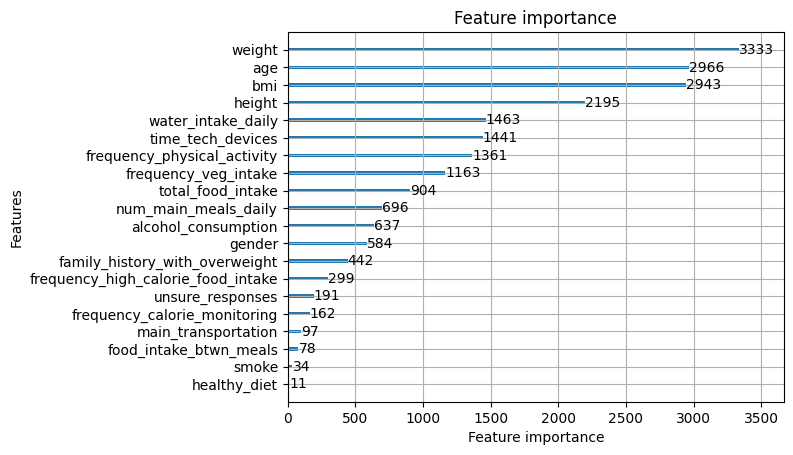

In [116]:
# feature importance
lgb.plot_importance(lgb_model, importance_type='split');

#### SVM extended to multiclass classification

In [119]:
# one hot encode and label encode categorical features 
X_train_svm = X_train.copy()
X_test_svm = X_test.copy()

print(f"before encoding: ")
print(X_train_svm.shape)
print(X_test_svm.shape)
print(f"\n after encoding: ")

X_train_svm = categorical_encode(df=X_train_svm)
X_test_svm = categorical_encode(df=X_test_svm)

print(X_train_svm.shape)
print(X_test_svm.shape)

before encoding: 
(16606, 21)
(4152, 21)

 after encoding: 
(16606, 24)
(4152, 24)


In [132]:
# scale to SD
for i in X_train_svm.columns:
    if np.issubdtype(X_train_svm[i].dtype, float):
        # train
        scaler = StandardScaler() 
        X_train_svm[i] = scaler.fit_transform(X_train_svm[[i]])
        # test
        scaler = StandardScaler() 
        X_test_svm[i] = scaler.fit_transform(X_test_svm[[i]])

print(X_train_svm.shape)
print(X_test_svm.shape)
        

(16606, 24)
(4152, 24)


In [140]:
# fit 
svm_model = SVC(kernel='linear', decision_function_shape='ovr', probability=True) 
svm_model.fit(X_train_svm,y_train)

SVC(kernel='linear', probability=True)

In [141]:
svm_y_pred = svm_model.predict(X_test_svm)
svm_y_pred_prob = svm_model.predict_proba(X_test_svm)

In [145]:
# evaluation
classification_evaluation(y_test=y_test, 
                          y_pred=svm_y_pred, 
                          y_predict_proba=svm_y_pred_prob,
                          labels=svm_model.classes_.tolist())

Confusion matrix: 

                     Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Insufficient_Weight                 96.0            4.0             0.0   
Normal_Weight                       11.0           82.0             0.0   
Obesity_Type_I                       0.0            0.0            86.0   
Obesity_Type_II                      0.0            0.0             4.0   
Obesity_Type_III                     0.0            0.0             0.0   
Overweight_Level_I                   1.0           11.0             1.0   
Overweight_Level_II                  0.0            2.0            13.0   

                     Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Insufficient_Weight              0.0               0.0                 0.0   
Normal_Weight                    0.0               0.0                 7.0   
Obesity_Type_I                   4.0               0.0                 2.0   
Obesity_Type_II                 95.0               0.0             

#### Hyperparameter turning of SVM

- kernel function, regularization, method for treating multiclass labels

In [147]:
svm_model2 = SVC(probability=True)

params_grid = {
    'kernel': ['poly'],
    'decision_function_shape': ['ovo','ovr'],
    'C': [0.1, 1, 10, 100],
    'degree': [2,3,4],
    'coef0': [0,1,2]
}

# grid search 
svm_grid_search = GridSearchCV(
    estimator=svm_model2,
    param_grid=params_grid,
    cv=5,
    verbose=1,
    n_jobs=-1
)

svm_grid_search.fit(X_train_svm,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'coef0': [0, 1, 2],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': [2, 3, 4], 'kernel': ['poly']},
             verbose=1)

In [148]:
# best params
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_

print(f"best params: {best_params}; best accuracy score: {best_score}")

best params: {'C': 0.1, 'coef0': 1, 'decision_function_shape': 'ovo', 'degree': 4, 'kernel': 'poly'}; best accuracy score: 0.8805249501421363


In [149]:
# using best model
svm_bestmodel_2 = svm_grid_search.best_estimator_
svm_y_pred_2 = svm_bestmodel_2.predict(X_test_svm)
svm_y_pred_prob_2 = svm_bestmodel_2.predict_proba(X_test_svm)

In [150]:
# evaluation
classification_evaluation(y_test=y_test, 
                          y_pred=svm_y_pred_2, 
                          y_predict_proba=svm_y_pred_prob_2,
                          labels=svm_bestmodel_2.classes_.tolist())

Confusion matrix: 

                     Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Insufficient_Weight                 95.0            4.0             0.0   
Normal_Weight                        8.0           84.0             0.0   
Obesity_Type_I                       0.0            0.0            86.0   
Obesity_Type_II                      0.0            0.0             2.0   
Obesity_Type_III                     0.0            0.0             0.0   
Overweight_Level_I                   1.0           11.0             2.0   
Overweight_Level_II                  0.0            1.0            11.0   

                     Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Insufficient_Weight              0.0               0.0                 0.0   
Normal_Weight                    0.0               0.0                 7.0   
Obesity_Type_I                   3.0               0.0                 2.0   
Obesity_Type_II                 97.0               0.0             

---

#### Predict test set 

- Out of the 4 models trained, LightGBM is the best performing one, even without hyperparameter tuning 

In [173]:
test_df = pd.read_csv('./dataset/test.csv')
results = test_df[['id']]
len(test_df)

13840

In [174]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

In [175]:
# rename columns
rename_cols_map = {"FAVC": "frequency_high_calorie_food_intake",
                   "FCVC": "frequency_veg_intake",
                   "NCP": "num_main_meals_daily",
                   "CAEC": "food_intake_btwn_meals",
                   "CH2O": "water_intake_daily",
                   "SCC": "frequency_calorie_monitoring",
                   "FAF": "frequency_physical_activity",
                   "TUE": "time_tech_devices",
                   "CALC": "alcohol_consumption",
                   "MTRANS": "main_transportation"
                   }

test_df.rename(columns=rename_cols_map, inplace=True)

test_df.columns = [i.lower() for i in test_df.columns]

test_df.drop(columns=['id'], axis=1, inplace=True)

test_df = add_new_features(df=test_df)

In [176]:
# handle categorical features 
for i in test_df.columns:
    if not np.issubdtype(test_df[i].dtype, np.number):
        # train
        label_encoder = LabelEncoder()
        test_df[i] = label_encoder.fit_transform(test_df[i])
        test_df[i] = test_df[i].astype('category')

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              13840 non-null  category
 1   age                                 13840 non-null  float64 
 2   height                              13840 non-null  float64 
 3   weight                              13840 non-null  float64 
 4   family_history_with_overweight      13840 non-null  category
 5   frequency_high_calorie_food_intake  13840 non-null  category
 6   frequency_veg_intake                13840 non-null  float64 
 7   num_main_meals_daily                13840 non-null  float64 
 8   food_intake_btwn_meals              13840 non-null  category
 9   smoke                               13840 non-null  category
 10  water_intake_daily                  13840 non-null  float64 
 11  frequency_calorie_monitoring

In [177]:
# predict
lgb_test_pred_prob = lgb_model.predict(test_df)

lgb_test_pred = np.argmax(lgb_test_pred_prob, axis=1)

lgb_test_pred = [{v:k for k,v in class_dict.items()}[i] for i in lgb_test_pred]

In [178]:
lgb_test_pred

['Obesity_Type_II',
 'Overweight_Level_I',
 'Obesity_Type_III',
 'Obesity_Type_I',
 'Obesity_Type_III',
 'Insufficient_Weight',
 'Insufficient_Weight',
 'Normal_Weight',
 'Overweight_Level_II',
 'Normal_Weight',
 'Insufficient_Weight',
 'Obesity_Type_III',
 'Obesity_Type_III',
 'Overweight_Level_II',
 'Obesity_Type_III',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Obesity_Type_I',
 'Obesity_Type_III',
 'Obesity_Type_I',
 'Normal_Weight',
 'Obesity_Type_III',
 'Obesity_Type_III',
 'Obesity_Type_II',
 'Overweight_Level_I',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_I',
 'Insufficient_Weight',
 'Obesity_Type_I',
 'Overweight_Level_II',
 'Obesity_Type_III',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Overweight_Level_I',
 'Overweight_Level_I',
 'Obesity_Type_I',
 'Normal_Weight',
 'Insufficient_Weight',
 'Overweight_Level_II',
 'Obesity_Type_II',
 'Overweight_Level_II',
 'Obesity_Type_II',
 'Overweight_Level_II',
 'Overweight_Level_I',
 'Insufficient_Weight',
 'Obesity_Type_I',
 '

In [183]:
results['NObeyesdad'] = lgb_test_pred

results.to_csv('submission.csv', index=False)